

# Ephaptic Coupling #

### Import stuff

In [1]:
%pylab inline

import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron
from custom_plots import plot_cell

Populating the interactive namespace from numpy and matplotlib


### Define morphology and cell parameters

https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=2488#tabs-1
https://sci-hub.tw/10.1038/382363a0
https://neuroelectro.org/neuron/111/

In [2]:
cellParameters = {
    'morphology' : 'morphology/pyramidal_layer5.hoc',
    'cm' : 0.75,                      
    'Ra' : 150,                
    'v_init' : -70, 
    'passive' : True,           # turn on NEURONs passive mechanism for all sections
    'nsegs_method' : None,      # spatial discretization method
#     'nsegs_method' : 'lambda_f', # spatial discretization method
#     'lambda_f' : 100,           # frequency where length constants are computed
    'dt' : 2**-6,               # simulation time step size
    'tstart' : 0,            # start time of simulation
    'tstop' : 400,              # stop simulation
    'celsius': 34,
    'pt3d' : True,
    'extracellular': True,
    'passive_parameters' : {'g_pas' : 1/30000, 'e_pas' : -70},
}

In [3]:
# # test with mod mechanisms

# #compile mod files every time, because of incompatibility with Mainen96 files:
# if "win32" in sys.platform:
#     pth = "pyramidal_mod/"
#     warn("no autompile of NMODL (.mod) files on Windows.\n" 
#          + "Run mknrndll from NEURON bash in the folder L5bPCmodelsEH/mod and rerun example script")
#     if not pth in neuron.nrn_dll_loaded:
#         neuron.h.nrn_load_dll(pth+"nrnmech.dll")
#     neuron.nrn_dll_loaded.append(pth)
# else:
#     os.system('''
#               cd morphology/pyramidal_mod/
#               nrnivmodl
#               ''')
#     neuron.load_mechanisms('morphology/pyramidal_mod/')

# cellParameters = {
#     'morphology' : 'morphology/pyramidal_layer5.hoc',
# #     'cm' : 0.75,                      
# #     'Ra' : 150,                
# #     'v_init' : -70, 
#     'passive' : None,           # turn on NEURONs passive mechanism for all sections
#     'nsegs_method' : None,      # spatial discretization method
#     'dt' : 2**-6,               # simulation time step size
#     'tstart' : 0,               # start time of simulation
#     'tstop' : 200,              # stop simulation
#     'celsius': 34,
#     'pt3d' : True,
#     'extracellular': True,
# #     'passive_parameters' : {'g_pas' : 0.000001, 'e_pas' : -65},
# }

## Create generator_cell

Synapse target index is: 0
Synapse target position is: [0. 0.]


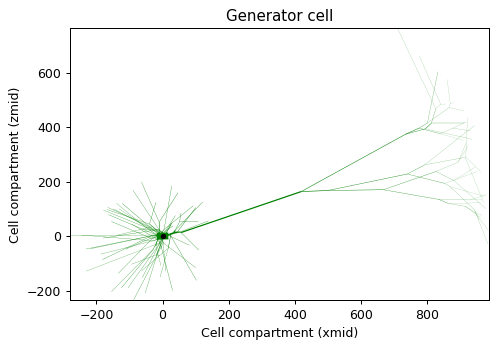

In [4]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
generator_cell = LFPy.Cell(**cellParameters)
generator_cell.set_rotation(x=4.729, y=-3.166)

# create synapse
synapse_parameters = {
    'idx' : generator_cell.get_closest_idx(x=0, y=0, z=0),  # place sinapse at soma coordinates
    'e' : 0,                     # reversal potential
    'syntype' : 'ExpSyn',        # synapse type
    'tau' : 15,                  # pyramidal synaptic time constant
    'weight' : 0.003,            # synaptic weight
    'record_current' : True,     # record synapse current
}

synapse = LFPy.Synapse(generator_cell, **synapse_parameters)
synapse.set_spike_times(np.array([95, 195]))      # spike times

# check synapse location 
positions = np.array(list(zip(generator_cell.xmid, generator_cell.zmid)))  # array all cell positions
synapse_index = generator_cell.get_closest_idx(x=0, y=0, z=0)              # find closest electrode to target position
synapse_pos = positions[synapse_index] 

print('Synapse target index is:', synapse_index)
print('Synapse target position is:', synapse_pos)

# plot generator cell morphology with synapse location
plt.figure(figsize=(6,4), dpi=90)
plot_cell(generator_cell, color='g')
plt.scatter(generator_cell.xmid[0],generator_cell.zmid[0], s=10, color='k')
plt.title('Generator cell')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

# define parameters for extracellular recording electrodes
electrodeParameters = {
    'sigma' : 0.6,                  # extracellular conductivity 0.6 to 0.24
    'x' : generator_cell.xmid+100,      
    'y' : generator_cell.ymid,
    'z' : generator_cell.zmid,
    'method' : 'soma_as_point',     #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*generator_cell.xmid.size), #surface normals
    'r' : 2.5,                      # contact site radius
    'n' : 20,                       # datapoints for averaging
}

# create extracellular electrode object for LFPs on grid in xz-plane
electrode = LFPy.RecExtElectrode(**electrodeParameters)

# simulate generator cell
generator_cell.simulate(electrode = electrode,rec_vmem=True)

### Plot Vmem in generator cell over time

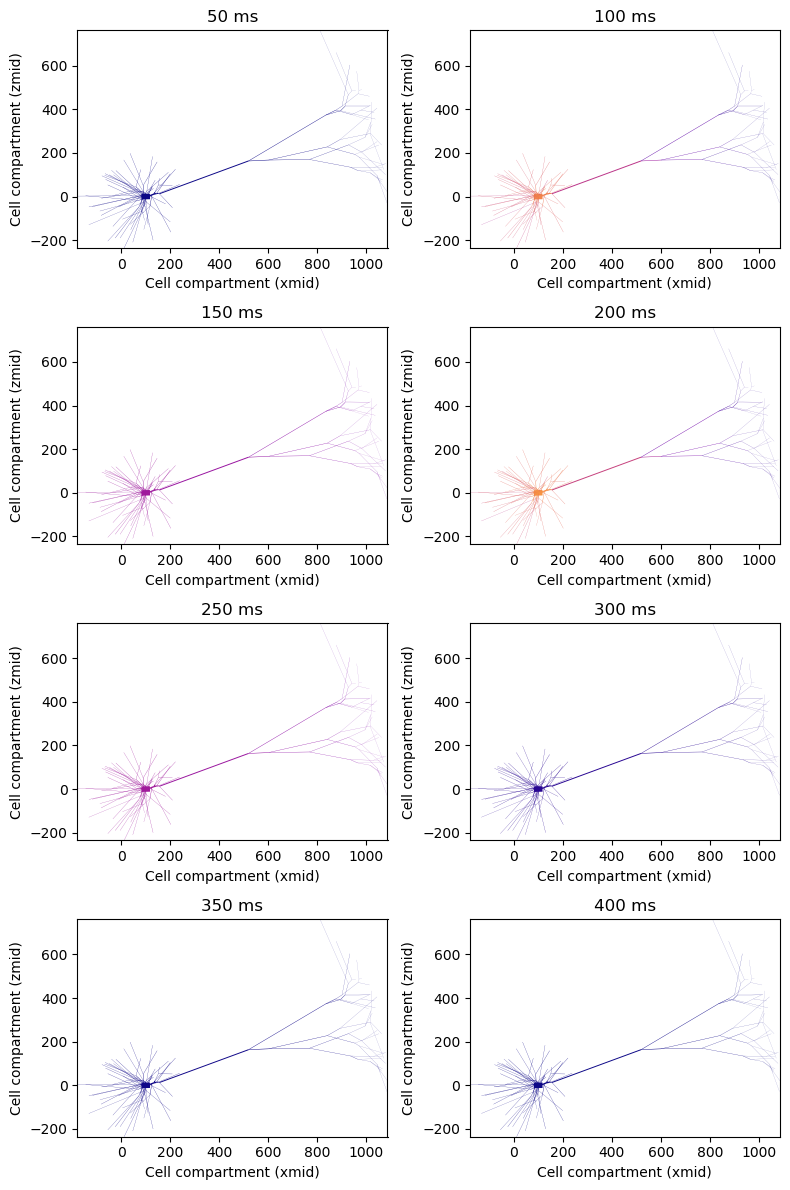

In [5]:
# plot generator cell vmem with morphology

timepoint_50 = int(50/(2**-6)) # simulation time point
timepoint_100 = int(100/(2**-6))
timepoint_150 = int(150/(2**-6))
timepoint_200 = int(200/(2**-6))
timepoint_250 = int(250/(2**-6))
timepoint_300 = int(300/(2**-6))
timepoint_350 = int(350/(2**-6))
timepoint_400 = int(400/(2**-6))

vmax = generator_cell.vmem.max()
vmin = generator_cell.vmem.min()

plt.figure(figsize=(8, 12), dpi=100)
plt.subplot(421)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_50], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('50 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(422)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_100], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('100 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(423)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_150], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('150 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(424)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_200], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('200 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(425)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_250], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('250 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(426)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_300], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('300 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(427)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_350], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('350 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(428)
plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,timepoint_400], palette='plasma',
             vmin=vmin, vmax=vmax)
plt.title('400 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.tight_layout()

# # plot generator cell vmem interactively over time
# def plot_time(t=100):
#     plot_cell(generator_cell, x_off=100, voltage=generator_cell.vmem[:,t], palette='plasma')
#     plt.title('Generator: membrane voltage over time')
# wdg.interact(plot_time)

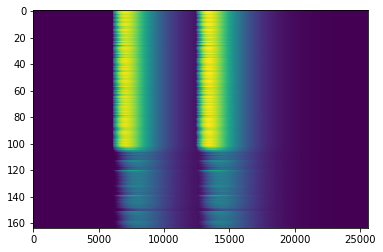

In [6]:
plt.imshow(generator_cell.vmem, aspect='auto')

## Creating receptor_cell

In [7]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
receptor_cell = LFPy.Cell(**cellParameters)
receptor_cell.set_rotation(x=4.729, y=-3.166)
receptor_cell.xmid += 100          # added distance of the electrodes to the receptor cell in x plane

# time of extracellular field simulation
t = np.arange(electrode.LFP.shape[1]) * receptor_cell.dt

# insert external field generated by the generator cell recorded in electrodes
receptor_cell.insert_v_ext(electrode.LFP, t)

# perform receptor cell simulation
receptor_cell.simulate(rec_vmem=True)

Overwriting custom temperature of 34.00. New temperature is 34.00


### Find index positions in generator_cell and receptor_cell

NameError: name 'gen_dend_pos' is not defined

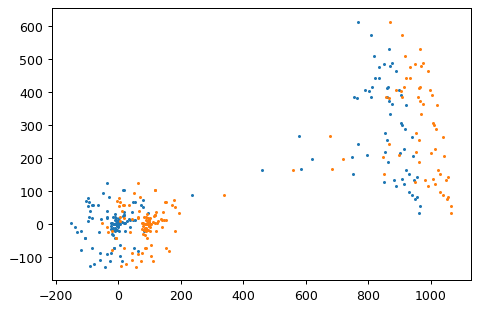

In [9]:
gen_positions = np.array(list(zip(generator_cell.xmid, generator_cell.zmid)))  # array all cell positions
rec_positions = np.array(list(zip(receptor_cell.xmid, receptor_cell.zmid)))  # array all cell positions

dend1_index = generator_cell.get_closest_idx(x=-100, y=0, z=-90)
dend2_index = generator_cell.get_closest_idx(x=500, y=200, z=0)

gen_dend1_pos = gen_positions[dend1_index] 
gen_dend2_pos = gen_positions[dend2_index] 

dend1_index = receptor_cell.get_closest_idx(x=0, y=0, z=-90)
dend2_index = receptor_cell.get_closest_idx(x=600, y=200, z=0)

rec_dend1_pos = rec_positions[dend1_index] 
rec_dend2_pos = rec_positions[dend2_index] 


# plot generator and receptor compartments with target
plt.figure(figsize=(6,4), dpi=90)
plt.scatter(generator_cell.xmid, generator_cell.zmid ,s=2)  # blue
plt.scatter(receptor_cell.xmid, receptor_cell.zmid ,s=2)    # orange
plt.scatter(gen_dend_pos[0],gen_dend_pos[1],s=10,color='r')       # black dot = target position 
plt.scatter(gen_axon_pos[0],gen_axon_pos[1],s=10,color='r')       # black dot = target position 
plt.scatter(rec_dend_pos[0],rec_dend_pos[1],s=10,color='k')       # black dot = target position 
plt.scatter(rec_axon_pos[0],rec_axon_pos[1],s=10,color='k')       # black dot = target position 
plt.title('Generator and receptor cells')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

### Plot Vmem in receptor cell over time

In [ ]:
plt.figure(figsize=(10,4), dpi=90)

# # plot vmem in each receptor cell compartment over time
# plt.subplot(121)
# plt.plot(receptor_cell.tvec,receptor_cell.vmem.T - receptor_cell.vmem.mean(axis=0).reshape(-1,1));
# plt.title('Receptor: membrane voltage of each cell compartment')
# plt.ylabel('Membrane voltage (mV)')
# plt.xlabel('Time (ms)')

# plot vmem of all receptor cell compartments over time
plt.plot(receptor_cell.tvec,receptor_cell.vmem.T);
plt.title('Receptor: membrane voltage of entire cell')
plt.ylabel('Membrane voltage (mV)')
plt.xlabel('Time (ms)')
# plt.yticks([-62.00015, -62.0001, -62.0000, -61.9999, -61.99985],['', -62.0001, -62.0000, -61.9999, ''])
# axis.ticklabel_format(axis='both', style='plain', scilimits=(-10,10))

In [ ]:
# plot receptor cell vmem with morphology

rec_vmax = receptor_cell.vmem.max()
rec_vmin = receptor_cell.vmem.min()

plt.figure(figsize=(8, 12), dpi=100)
plt.subplot(421)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_50], palette='plasma', vmin=rec_vmin, vmax=rec_vmax)
plt.title('50 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(422)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_100], palette='plasma', vmin=rec_vmin, vmax=rec_vmax)
plt.title('100 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(423)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_150], palette='plasma', vmin=rec_vmin, vmax=rec_vmax)
plt.title('150 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(424)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_200], palette='plasma', vmin=rec_vmin, vmax=rec_vmax)
plt.title('200 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(425)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_250], palette='plasma', vmin=rec_vmin, vmax=rec_vmax)
plt.title('250 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(426)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_300], palette='plasma', vmin=rec_vmin, vmax=rec_vmax)
plt.title('300 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(427)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_350], palette='plasma', vmin=rec_vmin, vmax=rec_vmax)
plt.title('350 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.subplot(428)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint_400], palette='plasma', vmin=rec_vmin, vmax=rec_vmax)
plt.title('400 ms')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

plt.tight_layout()

# # plot receptor cell vmem interactively over time
# def plot_time(t=100):
#     plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,t], palette='plasma', vmin=rec_vmin, vmax=rec_vmax)
#     plt.title('Receptor: membrane voltage over time')
# wdg.interact(plot_time)

In [ ]:
plt.imshow(-np.log10(np.abs(receptor_cell.vmem)), aspect='auto', vmin=-np.log10(np.abs(rec_vmin)), vmax=-np.log10(np.abs(rec_vmax)))

### Plot Vmem in generator_cell and receptor_cell 

In [ ]:
plt.figure(figsize=(8, 12), dpi=100)
plt.subplot(421)
plt.plot(generator_cell.tvec, synapse.i, 'r'), plt.title('Generator: synaptic current in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic current (pA)')

plt.subplot(423)
plt.plot(generator_cell.tvec, generator_cell.somav, 'k'), plt.title('Generator: Vmem in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(424)
plt.plot(receptor_cell.tvec, receptor_cell.somav, 'k'), plt.title('Receptor: Vmem in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(425)
plt.plot(generator_cell.tvec, generator_cell.vmem[dend_index], 'k'), plt.title('Generator: Vmem in dendrite')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(426)
plt.plot(receptor_cell.tvec, receptor_cell.vmem[dend_index], 'k'), plt.title('Receptor: Vmem in dendrite')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(427)
plt.plot(generator_cell.tvec, generator_cell.vmem[axon_index], 'k'), plt.title('Generator: Vmem in axon')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(428)
plt.plot(receptor_cell.tvec, receptor_cell.vmem[axon_index], 'k'), plt.title('Receptor: Vmem in axon')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.tight_layout()

print('Gen Vmem soma var:', max(generator_cell.somav)-min(generator_cell.somav))
print('Rec Vmem soma peak:', max(receptor_cell.somav))
print('Rec Vmem soma var:', max(receptor_cell.somav)-min(receptor_cell.somav))

print('Gen Vmem dend var:', max(generator_cell.vmem[dend_index])-min(generator_cell.vmem[dend_index]))
print('Rec Vmem dend peak:', max(receptor_cell.vmem[dend_index]))
print('Rec Vmem dend var:', max(receptor_cell.vmem[dend_index])-min(receptor_cell.vmem[dend_index]))

print('Gen Vmem axon var:', max(generator_cell.vmem[axon_index])-min(generator_cell.vmem[axon_index]))
print('Rec Vmem axon peak:', max(receptor_cell.vmem[axon_index]))
print('Rec Vmem axon var:', max(receptor_cell.vmem[axon_index])-min(receptor_cell.vmem[axon_index]))